In [2]:
import tsflex
print(tsflex.__version__)

0.2.3


## Get the data

In [3]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_ibi = load_empatica_data(["tmp", "acc", "ibi"])

In [4]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Irregular sampling rate

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Irregular sampling rate

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

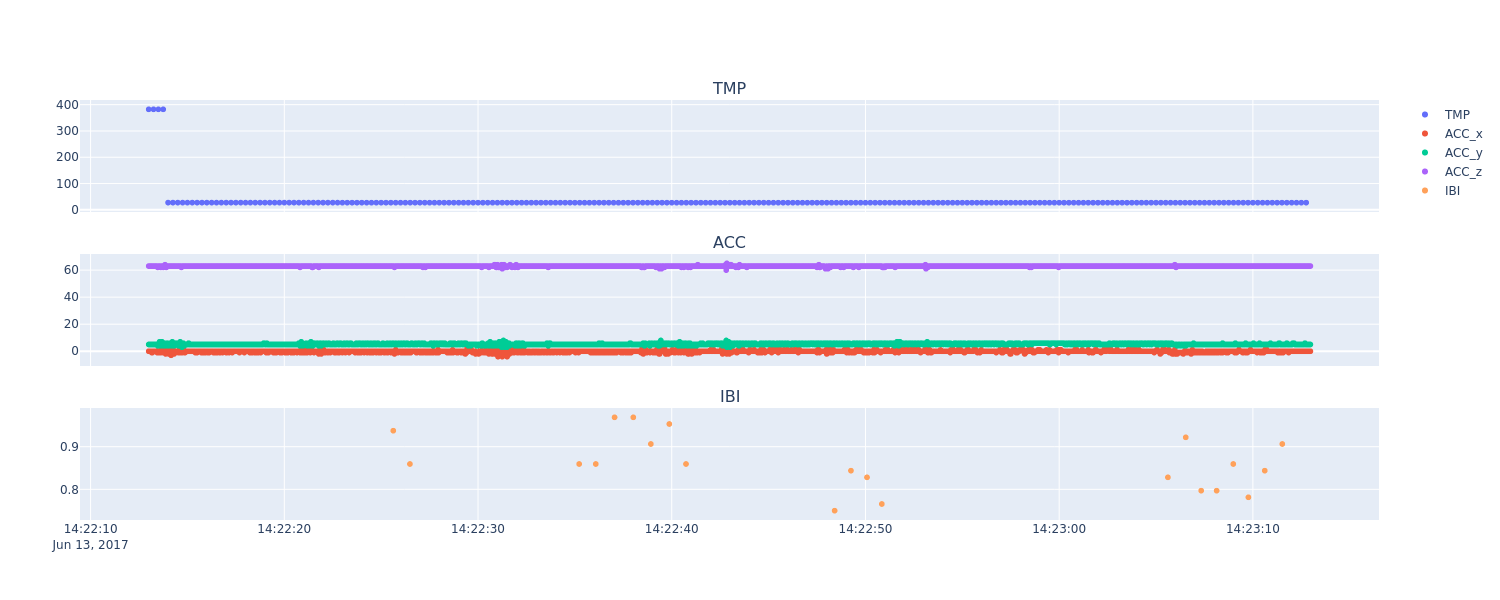

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer="png", width=1500)

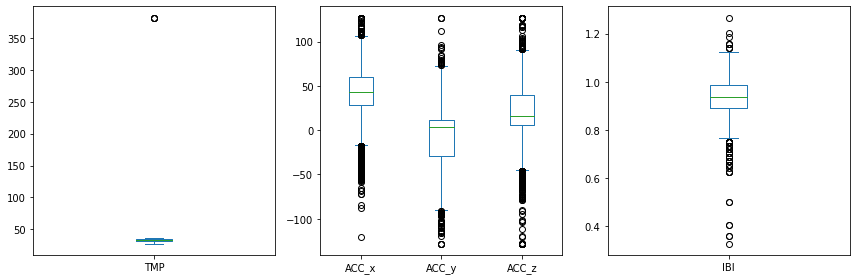

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

In [7]:
import pandas as pd; import numpy as np; from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig,  a_min=min_val, a_max=max_val)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe

[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
# Process the data
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

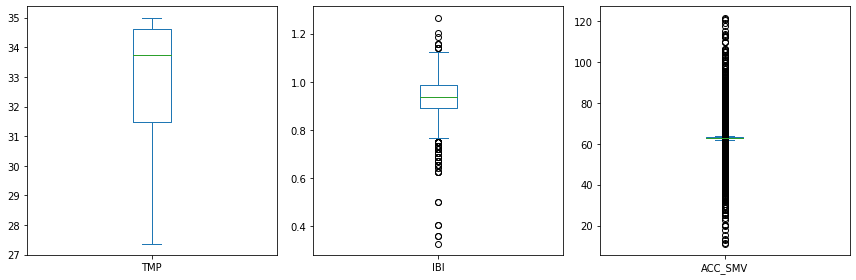

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction

In [10]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection
from tsflex.features.integrations import seglearn_feature_dict_wrapper
from tsflex.features.utils import make_robust

# Import / create the feature functions
from seglearn.feature_functions import base_features
def area(sig: np.ndarray): return np.sum(np.abs(sig))

# Create the feature descriptors
general_feats = MultipleFeatureDescriptors(
        functions=seglearn_feature_dict_wrapper(base_features()) + [area],
        series_names=["ACC_SMV", "TMP"],
        windows=["5min", "2.5min"], strides="2min",
)
ibi_feats = MultipleFeatureDescriptors(
    [make_robust(f) for f in [np.min, np.max, np.mean, np.std]] + [len],
    series_names="IBI", windows="5min", strides="2min"
)

# Create the feature collection & calculate the features
fc = FeatureCollection(feature_descriptors=[general_feats, ibi_feats])
fc

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['minimum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['maximum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mean_crossings'], {}),
		FeatureDescriptor - func: 

In [11]:
# Calculate the features
feat_df = fc.calculate(out_data, return_df=True, approve_sparsity=True)
feat_df

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__area__w=2m30s_s=2m,ACC_SMV__area__w=5m_s=2m,ACC_SMV__kurt__w=2m30s_s=2m,ACC_SMV__kurt__w=5m_s=2m,ACC_SMV__maximum__w=2m30s_s=2m,ACC_SMV__maximum__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,...,TMP__minimum__w=2m30s_s=2m,TMP__minimum__w=5m_s=2m,TMP__mse__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,TMP__skew__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__std__w=2m30s_s=2m,TMP__std__w=5m_s=2m,TMP__var__w=2m30s_s=2m,TMP__var__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:55.625578+02:00,1.912296e+07,NaN,302526.720671,NaN,20.390625,NaN,86.514759,NaN,63.026400,NaN,...,27.370001,NaN,466431.297484,NaN,0.413185,NaN,0.458309,NaN,0.210047,NaN
2017-06-13 14:26:55.625578+02:00,1.921744e+07,NaN,303308.108942,NaN,25.146123,NaN,92.325941,NaN,63.189189,NaN,...,28.350000,NaN,508482.890784,NaN,-0.559803,NaN,0.340962,NaN,0.116255,NaN
2017-06-13 14:27:25.625578+02:00,NaN,3.832505e+07,NaN,605774.919390,NaN,24.860844,NaN,92.325941,NaN,63.101554,...,NaN,27.370001,NaN,9.836452e+05,NaN,-0.184549,NaN,0.836146,NaN,0.699140
2017-06-13 14:28:55.625578+02:00,1.901170e+07,NaN,302022.798602,NaN,48.704834,NaN,76.211915,NaN,62.921416,NaN,...,29.430000,NaN,541186.399562,NaN,-0.612763,NaN,0.338179,NaN,0.114365,NaN
2017-06-13 14:29:25.625578+02:00,NaN,3.822945e+07,NaN,605340.002136,NaN,42.896242,NaN,92.325941,NaN,63.056250,...,NaN,28.350000,NaN,1.054534e+06,NaN,-0.351597,NaN,0.598841,NaN,0.358611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:15:25.625578+02:00,NaN,3.834805e+07,NaN,606282.999203,NaN,50.646254,NaN,99.697647,NaN,63.154479,...,NaN,30.549999,NaN,1.139886e+06,NaN,0.430827,NaN,0.143015,NaN,0.020453
2017-06-13 16:16:55.625578+02:00,1.935885e+07,NaN,304778.066186,NaN,63.096388,NaN,74.826914,NaN,63.495430,NaN,...,29.809999,NaN,560990.930128,NaN,-1.066263,NaN,0.357432,NaN,0.127758,NaN
2017-06-13 16:17:25.625578+02:00,NaN,3.852158e+07,NaN,607642.036107,NaN,48.840970,NaN,99.697647,NaN,63.296045,...,NaN,29.809999,NaN,1.127780e+06,NaN,-1.029276,NaN,0.363592,NaN,0.132199


Look at the features for IBI data and for the other data

In [12]:
ibi_features = feat_df[[c for c in feat_df.columns if 'IBI_' in c]]
ibi_features = ibi_features[ibi_features.isna().sum(axis=1) < len(ibi_features.columns)]
ibi_features

,IBI__amax__w=5m_s=2m,IBI__amin__w=5m_s=2m,IBI__len__w=5m_s=2m,IBI__mean__w=5m_s=2m,IBI__std__w=5m_s=2m
timestamp,,,,,
2017-06-13 14:27:25.625578+02:00,1.031297,0.750034,33.0,0.872199,0.064306
2017-06-13 14:29:25.625578+02:00,1.031297,0.406269,6.0,0.695344,0.244706
2017-06-13 14:31:25.625578+02:00,1.031297,0.406269,8.0,0.726596,0.221533
2017-06-13 14:33:25.625578+02:00,1.093800,0.406269,26.0,0.857611,0.142708
2017-06-13 14:35:25.625578+02:00,1.093800,0.625029,28.0,0.862763,0.114090
2017-06-13 14:37:25.625578+02:00,0.906291,0.625029,14.0,0.780170,0.067716
2017-06-13 14:39:25.625578+02:00,0.984420,0.656280,19.0,0.793622,0.074263
2017-06-13 14:41:25.625578+02:00,1.062549,0.656280,69.0,0.876399,0.075981
2017-06-13 14:43:25.625578+02:00,1.062549,0.796911,91.0,0.914877,0.055076


In [13]:
other_features = feat_df[[c for c in feat_df.columns if not 'IBI_' in c]]
other_features = other_features[other_features.isna().sum(axis=1) < len(other_features.columns)]
other_features

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__area__w=2m30s_s=2m,ACC_SMV__area__w=5m_s=2m,ACC_SMV__kurt__w=2m30s_s=2m,ACC_SMV__kurt__w=5m_s=2m,ACC_SMV__maximum__w=2m30s_s=2m,ACC_SMV__maximum__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,...,TMP__minimum__w=2m30s_s=2m,TMP__minimum__w=5m_s=2m,TMP__mse__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,TMP__skew__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__std__w=2m30s_s=2m,TMP__std__w=5m_s=2m,TMP__var__w=2m30s_s=2m,TMP__var__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:55.625578+02:00,1.912296e+07,NaN,302526.720671,NaN,20.390625,NaN,86.514759,NaN,63.026400,NaN,...,27.370001,NaN,466431.297484,NaN,0.413185,NaN,0.458309,NaN,0.210047,NaN
2017-06-13 14:26:55.625578+02:00,1.921744e+07,NaN,303308.108942,NaN,25.146123,NaN,92.325941,NaN,63.189189,NaN,...,28.350000,NaN,508482.890784,NaN,-0.559803,NaN,0.340962,NaN,0.116255,NaN
2017-06-13 14:27:25.625578+02:00,NaN,3.832505e+07,NaN,605774.919390,NaN,24.860844,NaN,92.325941,NaN,63.101554,...,NaN,27.370001,NaN,9.836452e+05,NaN,-0.184549,NaN,0.836146,NaN,0.699140
2017-06-13 14:28:55.625578+02:00,1.901170e+07,NaN,302022.798602,NaN,48.704834,NaN,76.211915,NaN,62.921416,NaN,...,29.430000,NaN,541186.399562,NaN,-0.612763,NaN,0.338179,NaN,0.114365,NaN
2017-06-13 14:29:25.625578+02:00,NaN,3.822945e+07,NaN,605340.002136,NaN,42.896242,NaN,92.325941,NaN,63.056250,...,NaN,28.350000,NaN,1.054534e+06,NaN,-0.351597,NaN,0.598841,NaN,0.358611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:15:25.625578+02:00,NaN,3.834805e+07,NaN,606282.999203,NaN,50.646254,NaN,99.697647,NaN,63.154479,...,NaN,30.549999,NaN,1.139886e+06,NaN,0.430827,NaN,0.143015,NaN,0.020453
2017-06-13 16:16:55.625578+02:00,1.935885e+07,NaN,304778.066186,NaN,63.096388,NaN,74.826914,NaN,63.495430,NaN,...,29.809999,NaN,560990.930128,NaN,-1.066263,NaN,0.357432,NaN,0.127758,NaN
2017-06-13 16:17:25.625578+02:00,NaN,3.852158e+07,NaN,607642.036107,NaN,48.840970,NaN,99.697647,NaN,63.296045,...,NaN,29.809999,NaN,1.127780e+06,NaN,-1.029276,NaN,0.363592,NaN,0.132199


## Plot the IBI features

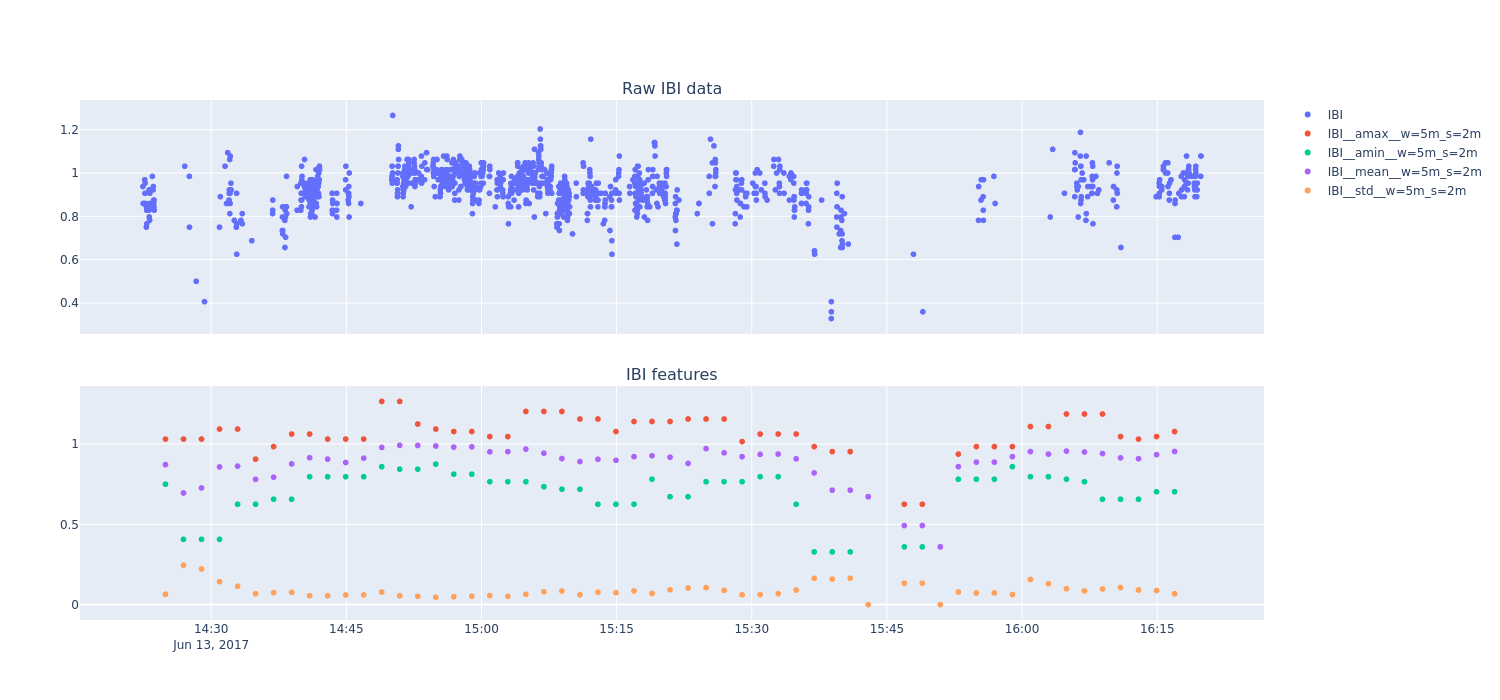

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For visualization purposes use window_idx = middle (this aligns the features better with the raw data)
feat_df = fc.calculate(
    out_data,
    return_df=True,
    approve_sparsity=True,
    window_idx="middle",
)

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, subplot_titles=["Raw IBI data", "IBI features"],
    vertical_spacing=0.1
)

fig.add_trace(
    go.Scattergl(x=df_ibi.index, y=df_ibi["IBI"], name="IBI", mode="markers"),
    row=1,
    col=1,
)

ibi_feats = [c for c in feat_df.columns if "IBI_" in c and "w=5m_" in c]

for col in ibi_feats:
    if "len" in col:
        continue
    sub_df = feat_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(height=2 * 350)

fig.show(renderer="png", width=1500)